# Load Data

In [11]:
!pip install kaggle

In [12]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"gunamunidilshi","key":"72d8f6d26347ee6e415138191a99d740"}'}

In [13]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [14]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

breast-histopathology-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip breast-histopathology-images.zip

In [ ]:
mkdir /content/train_data

In [ ]:
mkdir /content/train_data/benign

In [ ]:
mkdir /content/train_data/malignant

In [ ]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 78.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


# Import Libraries

In [15]:
import tensorflow as tf
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Flatten
import matplotlib.pyplot as plt
import pickle
import PIL
from PIL import Image
from math import exp, tanh
from tokenize import Exponent
from enum import Enum
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from datetime import date
from io import BytesIO
from IPython import display
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import base64
import pandas as pd
import seaborn as sns
import uuid
import glob
import shutil

<ipython-input-15-76f31fbbc3de>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


# Data Preprocessing

In [16]:
#create benign image dataset without duplicates

# Get all png files from group of folders
png_files = glob.glob("/content/**/0/*.png", recursive=True)[:20000]

# Move the png files to the dataset folder and filter duplicates
for png_file in png_files:
    if not os.path.exists("/content/train_data/benign/" + os.path.basename(png_file)):
        shutil.move(png_file, "/content/train_data/benign/")

In [17]:
#create malignant image dataset without duplicates

# Get all png files in group of folders
png_files = glob.glob("/content/**/1/*.png", recursive=True)[:20000]

# Move the png files to the dataset folder
for png_file in png_files:
    if not os.path.exists("/content/train_data/malignant/" + os.path.basename(png_file)):
        shutil.move(png_file, "/content/train_data/malignant/")

In [18]:
data_dir= "/content/train_data"

In [19]:
batch_size = 32
img_height = 50
img_width = 50

In [20]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
)

Found 28707 files belonging to 2 classes.
Using 22966 files for training.


In [21]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
)

Found 28707 files belonging to 2 classes.
Using 5741 files for validation.


In [22]:
class_names = train_ds.class_names
print(class_names)

['benign', 'malignant']


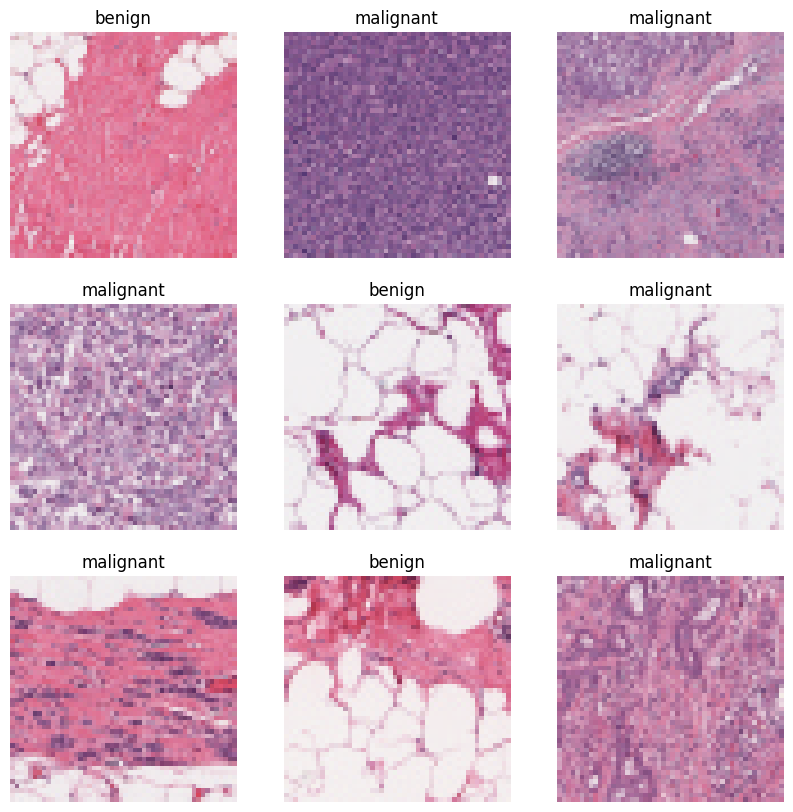

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [24]:
for image_batch, labels_batch in train_ds:
      print(image_batch.shape)
      print(labels_batch.shape)
      break

(32, 50, 50, 3)
(32,)


In [25]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [26]:
normalization_layer = layers.Rescaling(1./255)

In [27]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.35686275 0.9843138


In [28]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

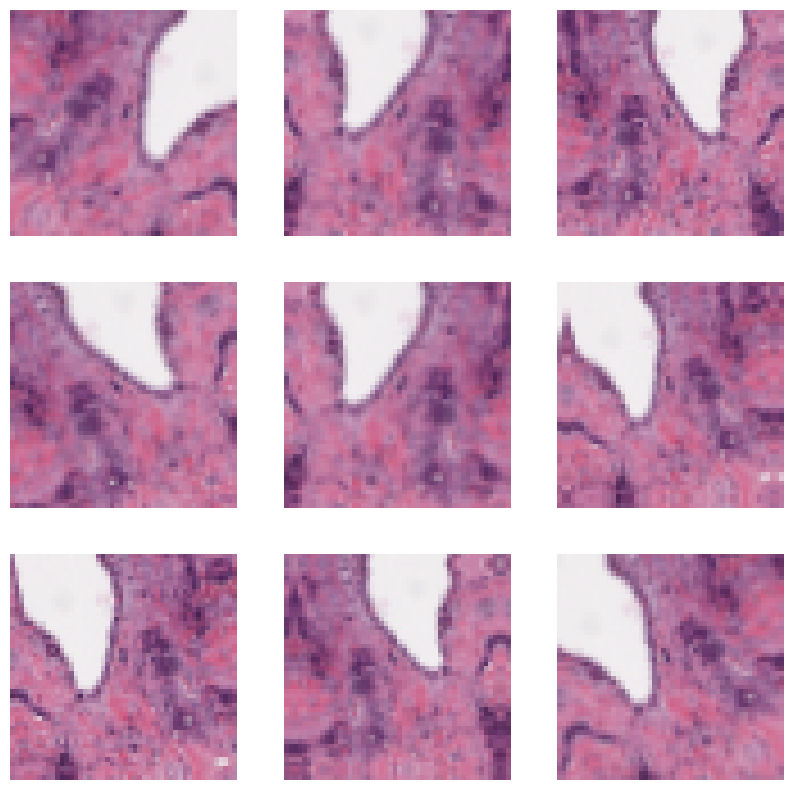

In [29]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [30]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 50, 50, 3)         0         
                                                                 
 rescaling_1 (Rescaling)     (None, 50, 50, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 50, 50, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 25, 25, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 32)        0         
 g2D)                                                 

In [33]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
718/718 [==============================] - 97s 132ms/step - loss: 0.4272 - accuracy: 0.8049 - val_loss: 0.4218 - val_accuracy: 0.7868
Epoch 2/20
718/718 [==============================] - 88s 122ms/step - loss: 0.3896 - accuracy: 0.8245 - val_loss: 0.3521 - val_accuracy: 0.8427
Epoch 3/20
718/718 [==============================] - 79s 110ms/step - loss: 0.3700 - accuracy: 0.8336 - val_loss: 0.3325 - val_accuracy: 0.8521
Epoch 4/20
718/718 [==============================] - 85s 118ms/step - loss: 0.3634 - accuracy: 0.8375 - val_loss: 0.3702 - val_accuracy: 0.8314
Epoch 5/20
718/718 [==============================] - 81s 112ms/step - loss: 0.3547 - accuracy: 0.8448 - val_loss: 0.3587 - val_accuracy: 0.8352
Epoch 6/20
718/718 [==============================] - 85s 118ms/step - loss: 0.3412 - accuracy: 0.8537 - val_loss: 0.3877 - val_accuracy: 0.8197
Epoch 7/20
718/718 [==============================] - 82s 115ms/step - loss: 0.3312 - accuracy: 0.8577 - val_loss: 0.3269 - val_ac

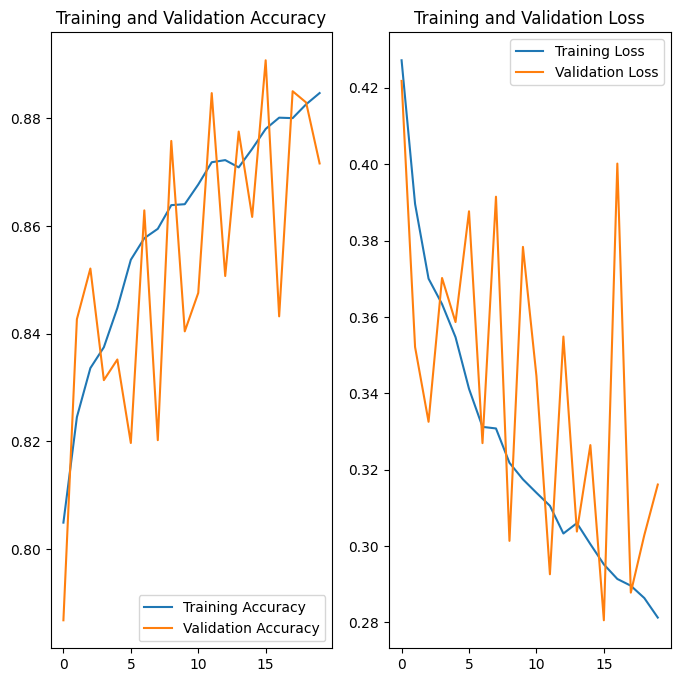

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

180/180 [==============================] - 9s 47ms/step
Accuracy: 0.8716251524124717
Precision: 0.8498328619182309
Recall: 0.9557547715442453
F1 Score: 0.8996869470532189


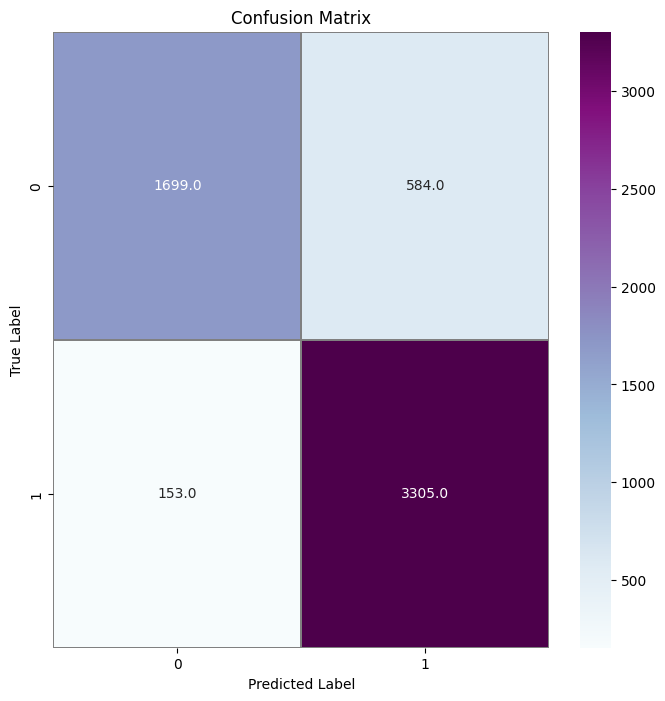

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Make predictions on the validation dataset
val_predictions = model.predict(val_ds)
val_labels = []

# Extract the true labels from the validation dataset
for images, labels in val_ds:
    val_labels.extend(labels.numpy())

# Convert predictions to class labels (0 or 1)
val_pred_labels = np.argmax(val_predictions, axis=-1)

# Calculate metrics
accuracy = accuracy_score(val_labels, val_pred_labels)
precision = precision_score(val_labels, val_pred_labels)
recall = recall_score(val_labels, val_pred_labels)
f1 = f1_score(val_labels, val_pred_labels)
confusion = confusion_matrix(val_labels, val_pred_labels)

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

plt.figure(figsize=(8, 8))
sns.heatmap(confusion, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
DATADIR = "/content/10254/1/10254_idx5_x1601_y1301_class1.png"

In [ ]:
img = tf.keras.utils.load_img(
    DATADIR, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 139ms/step
This image most likely belongs to malignant with a 99.13 percent confidence.
